In [69]:
# Add Dependencies and Setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [70]:
# Create path to data files
mouse_metadata_path = "raw_data/mouse_metadata.csv"
study_results_path = "raw_data/study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

In [71]:
# Preview mouse_metadata
mouse_metadata.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g)
0,k403,Ramicane,Male,21,16
1,s185,Capomulin,Female,3,17
2,x401,Capomulin,Female,16,15
3,m601,Capomulin,Male,22,17
4,g791,Ramicane,Male,11,16


In [72]:
# Preview study_results
study_results.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [73]:
# Combine the data into a single dataset
capomulin_study_data = pd.merge(mouse_metadata, study_results, on="Mouse ID")
capomulin_study_data.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [74]:
# Ensure capomulin_study_data is a clean dataset by checking for duplicate Timepoint values for each Mouse ID
duplicate_timepoints = capomulin_study_data[capomulin_study_data.duplicated(subset=["Mouse ID", "Timepoint"], keep=False)]

if not duplicate_timepoints.empty:
    print("Duplicate Timepoints found in capomulin_study_data")
    print(duplicate_timepoints)
else:
    print("No duplicate Timepoints found in capomulin_study_data")

Duplicate Timepoints found in capomulin_study_data
    Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
908     g989     Propriva  Female          21          26          0   
909     g989     Propriva  Female          21          26          0   
910     g989     Propriva  Female          21          26          5   
911     g989     Propriva  Female          21          26          5   
912     g989     Propriva  Female          21          26         10   
913     g989     Propriva  Female          21          26         10   
914     g989     Propriva  Female          21          26         15   
915     g989     Propriva  Female          21          26         15   
916     g989     Propriva  Female          21          26         20   
917     g989     Propriva  Female          21          26         20   

     Tumor Volume (mm3)  Metastatic Sites  
908           45.000000                 0  
909           45.000000                 0  
910           48.786801 

In [75]:
# Group duplicate_timepoints by Mouse ID and Timepoint taking the mean of the duplicate Tumor Volume (mm3) and Metastatic Sites values
group_duplicate_timepoints = duplicate_timepoints.groupby(["Mouse ID", "Timepoint"]).agg({"Tumor Volume (mm3)": "mean", "Metastatic Sites": "mean"}).reset_index()
print(group_duplicate_timepoints)

  Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
0     g989          0           45.000000               0.0
1     g989          5           48.178597               0.0
2     g989         10           50.812842               0.0
3     g989         15           52.383936               0.5
4     g989         20           54.991886               1.0


In [76]:
# Mupltiply the Tumor Volume (mm3) and Metastatic Sites values by -1 in group_duplicate_timepoints
group_duplicate_timepoints["Tumor Volume (mm3)"] = group_duplicate_timepoints["Tumor Volume (mm3)"] * -1
group_duplicate_timepoints["Metastatic Sites"] = group_duplicate_timepoints["Metastatic Sites"] * -1
print(group_duplicate_timepoints)

  Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
0     g989          0          -45.000000              -0.0
1     g989          5          -48.178597              -0.0
2     g989         10          -50.812842              -0.0
3     g989         15          -52.383936              -0.5
4     g989         20          -54.991886              -1.0


In [77]:
# Compare the group_duplicate_timepoints data with the fist instance of each Mouse ID and Timepoint in duplicate_timepoints
first_instance = duplicate_timepoints.drop_duplicates(subset=["Mouse ID", "Timepoint"], keep="first").drop(columns=["Drug Regimen", "Sex", "Age_months", "Weight (g)"])
print(first_instance)


    Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
908     g989          0           45.000000                 0
910     g989          5           48.786801                 0
912     g989         10           51.745156                 0
914     g989         15           51.325852                 1
916     g989         20           55.326122                 1


In [78]:
# Merge the first_instance data with the group_duplicate_timepoints data using the Mouse ID and Timepoint columns and sum the Tumor Volume (mm3) and Metastatic Sites values
duplicate_test = pd.merge(first_instance, group_duplicate_timepoints, on=["Mouse ID", "Timepoint"], suffixes=("_first", "_mean"))
duplicate_test["Tumor Volume (mm3)"] = duplicate_test["Tumor Volume (mm3)_first"] + duplicate_test["Tumor Volume (mm3)_mean"]
duplicate_test["Metastatic Sites"] = duplicate_test["Metastatic Sites_first"] + duplicate_test["Metastatic Sites_mean"]
duplicate_test = duplicate_test.drop(columns=["Tumor Volume (mm3)_first", "Metastatic Sites_first", "Tumor Volume (mm3)_mean", "Metastatic Sites_mean"])
print(duplicate_test)


  Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
0     g989          0            0.000000               0.0
1     g989          5            0.608205               0.0
2     g989         10            0.932314               0.0
3     g989         15           -1.058084               0.5
4     g989         20            0.334236               0.0


In [79]:
# Display any Mouse ID in which the Tumor Volume (mm3) or Metastatic Sites values are not equal to 0
duplicate_test = duplicate_test[(duplicate_test["Tumor Volume (mm3)"] != 0) | (duplicate_test["Metastatic Sites"] != 0)]
print(duplicate_test)


  Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
1     g989          5            0.608205               0.0
2     g989         10            0.932314               0.0
3     g989         15           -1.058084               0.5
4     g989         20            0.334236               0.0


In [80]:
# List unique Mouse ID values in duplicate_test
duplicate_mice = duplicate_test["Mouse ID"].unique()
print(duplicate_mice)

['g989']


In [81]:
# Drop the Mouse ID values in duplicate_mice from capomulin_study_data and reset the index
capomulin_study_data_clean = capomulin_study_data[~capomulin_study_data["Mouse ID"].isin(duplicate_mice)].reset_index(drop=True)
capomulin_study_data_clean.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [82]:
# If there were duplicate enetries that were double entries (All data was equal for every double entry) in the capomulin_study_data dataset. This is where I would drop the duplicates and keep the first entry.

In [83]:
# Ensure capomulin_study_data_clean is a clean dataset by checking for duplicate Timepoint values for each Mouse ID again
duplicate_timepoints_2 = capomulin_study_data_clean[capomulin_study_data_clean.duplicated(subset=["Mouse ID", "Timepoint"], keep=False)]

if not duplicate_timepoints_2.empty:
    print("Duplicate Timepoints found in capomulin_study_data_clean")
    print(duplicate_timepoints_2)
else:
    print("No duplicate Timepoints found in capomulin_study_data_clean")

No duplicate Timepoints found in capomulin_study_data_clean


In [84]:
# Save the cleaned dataset to a new CSV file
import os
cleaned_data_path = os.path.join("cleaned_data", "capomulin_study_data_clean.csv")
capomulin_study_data_clean.to_csv(cleaned_data_path, index=False)
print(f"Cleaned data saved to {cleaned_data_path}")


Cleaned data saved to cleaned_data\capomulin_study_data_clean.csv


In [85]:
# Delete tumor_volume_change DataFrame and set it to None
tumor_volume_change = None

In [86]:
# Create a copy of capomulin_study_data_clean DataFrame and add "Tumor Volume (mm3) Change" column to it
csdc_tumor_volume_change = capomulin_study_data_clean.copy()
csdc_tumor_volume_change["Tumor Volume (mm3) Change"] = 0.0
csdc_tumor_volume_change.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change
0,k403,Ramicane,Male,21,16,0,45.000000,0,0.0
1,k403,Ramicane,Male,21,16,5,38.825898,0,0.0
2,k403,Ramicane,Male,21,16,10,35.014271,1,0.0
3,k403,Ramicane,Male,21,16,15,34.223992,1,0.0
4,k403,Ramicane,Male,21,16,20,32.997729,1,0.0


In [186]:
# Set the initial Tumor Volume (mm3) for each Mouse ID
initial_tumor_volume = csdc_tumor_volume_change.groupby("Mouse ID").first().reset_index()
initial_tumor_volume = initial_tumor_volume[["Mouse ID", "Tumor Volume (mm3)"]]
initial_tumor_volume = initial_tumor_volume.rename(columns={"Tumor Volume (mm3)": "Initial Tumor Volume (mm3)"})
initial_tumor_volume

,Mouse ID,Initial Tumor Volume (mm3)
0,a203,45.0
1,a251,45.0
2,a262,45.0
3,a275,45.0
4,a366,45.0
...,...,...
243,z435,45.0
244,z578,45.0
245,z581,45.0
246,z795,45.0


In [88]:
# Use the initial_tumor_volume DataFrame to set the "Initial Tumor Volume (mm3)" for each Mouse ID in the csdc_tumor_volume_change DataFrame
csdc_tumor_volume_change = pd.merge(csdc_tumor_volume_change, initial_tumor_volume, on="Mouse ID")
csdc_tumor_volume_change.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change,Initial Tumor Volume (mm3)
0,k403,Ramicane,Male,21,16,0,45.000000,0,0.0,45.0
1,k403,Ramicane,Male,21,16,5,38.825898,0,0.0,45.0
2,k403,Ramicane,Male,21,16,10,35.014271,1,0.0,45.0
3,k403,Ramicane,Male,21,16,15,34.223992,1,0.0,45.0
4,k403,Ramicane,Male,21,16,20,32.997729,1,0.0,45.0


In [89]:
# Calculate the "Tumor Volume (mm3) Change" for each Mouse ID in the csdc_tumor_volume_change DataFrame
csdc_tumor_volume_change["Tumor Volume (mm3) Change"] = csdc_tumor_volume_change["Tumor Volume (mm3)"] - csdc_tumor_volume_change["Initial Tumor Volume (mm3)"]
csdc_tumor_volume_change.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change,Initial Tumor Volume (mm3)
0,k403,Ramicane,Male,21,16,0,45.000000,0,0.000000,45.0
1,k403,Ramicane,Male,21,16,5,38.825898,0,-6.174102,45.0
2,k403,Ramicane,Male,21,16,10,35.014271,1,-9.985729,45.0
3,k403,Ramicane,Male,21,16,15,34.223992,1,-10.776008,45.0
4,k403,Ramicane,Male,21,16,20,32.997729,1,-12.002271,45.0


In [90]:
# Add a ["% Size Reduction"] column to the csdc_tumor_volume_change DataFrame
csdc_tumor_volume_change["Tumor Volume % Reduction"] = (csdc_tumor_volume_change["Tumor Volume (mm3) Change"] / csdc_tumor_volume_change["Initial Tumor Volume (mm3)"]) * 100
csdc_tumor_volume_change.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change,Initial Tumor Volume (mm3),Tumor Volume % Reduction
0,k403,Ramicane,Male,21,16,0,45.000000,0,0.000000,45.0,0.000000
1,k403,Ramicane,Male,21,16,5,38.825898,0,-6.174102,45.0,-13.720227
2,k403,Ramicane,Male,21,16,10,35.014271,1,-9.985729,45.0,-22.190508
3,k403,Ramicane,Male,21,16,15,34.223992,1,-10.776008,45.0,-23.946685
4,k403,Ramicane,Male,21,16,20,32.997729,1,-12.002271,45.0,-26.671714


In [91]:
# Save the csdc_tumor_volume_change DataFrame to a new CSV file
csdc_tumor_volume_change_path = os.path.join("cleaned_data", "capomulin_study_data_clean_tumor_volume_change.csv")
csdc_tumor_volume_change.to_csv(csdc_tumor_volume_change_path, index=False)
print(f"Cleaned data with Tumor Volume Change saved to {csdc_tumor_volume_change_path}")

Cleaned data with Tumor Volume Change saved to cleaned_data\capomulin_study_data_clean_tumor_volume_change.csv


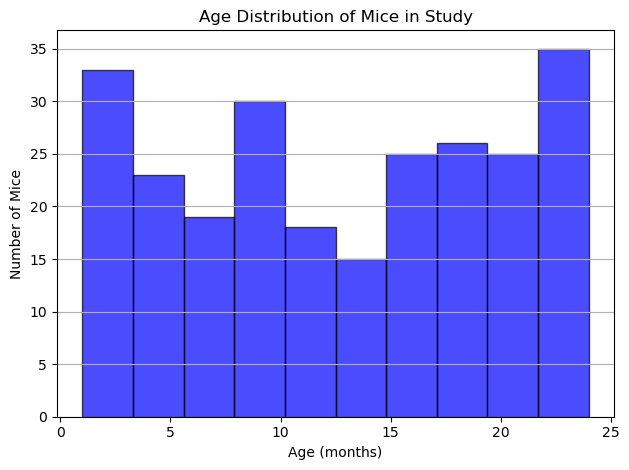

In [92]:
# Create a histogram of the age distribution of the mice in the study using the mouse_metadata DataFrame
plt.hist(mouse_metadata["Age_months"], bins=10, color="blue", alpha=0.7, edgecolor="black")
plt.title("Age Distribution of Mice in Study")
plt.xlabel("Age (months)")
plt.ylabel("Number of Mice")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [153]:
# Create a copy of the csdc_tumor_volume_change DataFrame and sort by ["Timepoint"] smallest to largest
csdc_tumor_sort = csdc_tumor_volume_change.sort_values("Timepoint")

# Create last_timepoint DataFrame with the largest Timepoint for each Mouse ID in the csdc_tumor_volume_change DataFrame
last_timepoint = csdc_tumor_sort.groupby("Mouse ID").last().reset_index()
last_timepoint

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change,Initial Tumor Volume (mm3),Tumor Volume % Reduction
0,a203,Infubinol,Female,20,23,45,67.973419,2,22.973419,45.0,51.052042
1,a251,Infubinol,Female,21,25,45,65.525743,1,20.525743,45.0,45.612762
2,a262,Placebo,Female,17,29,45,70.717621,4,25.717621,45.0,57.150268
3,a275,Ceftamin,Female,20,28,45,62.999356,3,17.999356,45.0,39.998569
4,a366,Stelasyn,Female,16,29,30,63.440686,1,18.440686,45.0,40.979303
...,...,...,...,...,...,...,...,...,...,...,...
243,z435,Propriva,Female,12,26,10,48.710661,0,3.710661,45.0,8.245914
244,z578,Ramicane,Male,11,16,45,30.638696,0,-14.361304,45.0,-31.914009
245,z581,Infubinol,Female,24,25,45,62.754451,3,17.754451,45.0,39.454336
246,z795,Naftisol,Female,13,29,45,65.741070,3,20.741070,45.0,46.091267


In [234]:
csdc_tumor_sort

# Create a copy of csdc_tumor_sort DataFrame and drop all rows with Timepoint not equal to 45
csdc_tumor_sort_45 = csdc_tumor_sort[csdc_tumor_sort["Timepoint"] == 45]
csdc_tumor_sort_45

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change,Initial Tumor Volume (mm3),Tumor Volume % Reduction
483,a262,Placebo,Female,17,29,45,70.717621,4,25.717621,45.0,57.150268
1800,y163,Infubinol,Female,17,27,45,67.685569,3,22.685569,45.0,50.412375
903,g570,Propriva,Male,16,29,45,70.492788,2,25.492788,45.0,56.650639
493,a275,Ceftamin,Female,20,28,45,62.999356,3,17.999356,45.0,39.998569
949,i635,Propriva,Male,21,26,45,58.633404,3,13.633404,45.0,30.296454
...,...,...,...,...,...,...,...,...,...,...,...
1149,l733,Ceftamin,Female,4,30,45,64.299830,1,19.299830,45.0,42.888511
1750,x402,Stelasyn,Male,21,28,45,61.619606,3,16.619606,45.0,36.932458
59,s508,Ramicane,Male,1,17,45,30.276232,0,-14.723768,45.0,-32.719485
360,g316,Capomulin,Female,22,22,45,40.159220,2,-4.840780,45.0,-10.757288


In [189]:
# This data as is cannot be used in the final analysis because all the mice did not make it to the final timepoint. The data in which the final Timepoint < 45 could be dropped, but that is not fun.
# Instead, I will normalize the data points in which the final Timepoint > 45 using the data set where the final Timepoint = 45.

# Create a copy of the csdc_tumor_volume_change DataFrame
csdc_tumor_volume_change_ftp_45 = csdc_tumor_volume_change.copy()

# Using the last_timepoint DataFrame, drop all rows in which the Timepoint is equal to 45
last_timepoint_less45 = last_timepoint[last_timepoint["Timepoint"] != 45]
csdc_tumor_volume_change_ftp_45 = csdc_tumor_volume_change_ftp_45[~csdc_tumor_volume_change_ftp_45["Mouse ID"].isin(last_timepoint_less45["Mouse ID"])]
csdc_tumor_volume_change_ftp_45

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change,Initial Tumor Volume (mm3),Tumor Volume % Reduction
0,k403,Ramicane,Male,21,16,0,45.000000,0,0.000000,45.0,0.000000
1,k403,Ramicane,Male,21,16,5,38.825898,0,-6.174102,45.0,-13.720227
2,k403,Ramicane,Male,21,16,10,35.014271,1,-9.985729,45.0,-22.190508
3,k403,Ramicane,Male,21,16,15,34.223992,1,-10.776008,45.0,-23.946685
4,k403,Ramicane,Male,21,16,20,32.997729,1,-12.002271,45.0,-26.671714
...,...,...,...,...,...,...,...,...,...,...,...
1875,z969,Naftisol,Male,9,30,25,63.145652,2,18.145652,45.0,40.323671
1876,z969,Naftisol,Male,9,30,30,65.841013,3,20.841013,45.0,46.313362
1877,z969,Naftisol,Male,9,30,35,69.176246,4,24.176246,45.0,53.724991
1878,z969,Naftisol,Male,9,30,40,70.314904,4,25.314904,45.0,56.255342


In [190]:
# Ensure the csdc_tumor_volume_change_ftp_45 DataFrame only contains Mouse ID values in which the final Timepoint is equal to 45
csdc_tumor_volume_change_sortby = csdc_tumor_volume_change_ftp_45.sort_values("Timepoint")

last_timepoint_check = csdc_tumor_volume_change_sortby.groupby("Mouse ID").last().reset_index()
last_timepoint_check["Timepoint"].unique()

array([45], dtype=int64)

In [191]:
# Create a copy of the csdc_tumor_volume_change_ftp_45 DataFrame
csdc_tumor_volume_change_ftp_45_tpa = csdc_tumor_volume_change_ftp_45.copy()

# Calculate the number of unique "Mouse ID" values for each "Drug Regimen" in the csdc_tumor_volume_change_ftp_45 DataFrame
unique_mice_per_dr_ftp_45 = csdc_tumor_volume_change_ftp_45.groupby("Drug Regimen")["Mouse ID"].nunique()
unique_mice_per_dr_ftp_45

Drug Regimen
Capomulin    21
Ceftamin     13
Infubinol     9
Ketapril     11
Naftisol     13
Placebo      11
Propriva      7
Ramicane     20
Stelasyn     11
Zoniferol    14
Name: Mouse ID, dtype: int64

In [193]:
# Group the csdc_tumor_volume_change_ftp_45_tpa DataFrame by "Drug Regimen" and "Timepoint" and calculate the mean "Tumor Volume (mm3)" for each group
mean_tumor_volume_per_dr_ftp_45_tpa = csdc_tumor_volume_change_ftp_45_tpa.groupby(["Drug Regimen", "Timepoint"])["Tumor Volume (mm3)"].mean()
mean_tumor_volume_per_dr_ftp_45_tpa

# Create a DataFrame with the mean "Tumor Volume (mm3)" for each "Drug Regimen" and "Timepoint"
mean_tumor_volume_per_dr_ftp_45_tpa_df = mean_tumor_volume_per_dr_ftp_45_tpa.reset_index()
mean_tumor_volume_per_dr_ftp_45_tpa_df

,Drug Regimen,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,45.000000
1,Capomulin,5,44.638812
2,Capomulin,10,43.288693
3,Capomulin,15,42.241369
4,Capomulin,20,41.046149
...,...,...,...
95,Zoniferol,25,55.315109
96,Zoniferol,30,57.520661
97,Zoniferol,35,60.089372
98,Zoniferol,40,62.916692


In [195]:
# Create a new DataFrame to hold the values for the linear regression analysis with columns for "Drug Regimen", "m", "b", "r", "r^2", "p", and "stderr"
linear_regression_analysis = []

# Create a list of unique "Drug Regimen" values in the mean_tumor_volume_per_dr_ftp_45_tpa_df DataFrame
unique_drug_regimens = mean_tumor_volume_per_dr_ftp_45_tpa_df["Drug Regimen"].unique()

# Loop through the unique_drug_regimens list and perform a linear regression analysis on the mean_tumor_volume_per_dr_ftp_45_tpa_df DataFrame for each "Drug Regimen"
for drug in unique_drug_regimens:
    # Filter the mean_tumor_volume_per_dr_ftp_45_tpa_df DataFrame for the current "Drug Regimen"
    drug_data = mean_tumor_volume_per_dr_ftp_45_tpa_df[mean_tumor_volume_per_dr_ftp_45_tpa_df["Drug Regimen"] == drug]
    # Perform a linear regression analysis on the "Timepoint" and "Tumor Volume (mm3)" columns
    m, b, r, p, stderr = st.linregress(drug_data["Timepoint"], drug_data["Tumor Volume (mm3)"])
    # Calculate the r^2 value
    r_squared = r ** 2
    # Append the results to the list
    linear_regression_analysis.append({"Drug Regimen": drug, "m": m, "b": b, "r": r, "r^2": r_squared, "p": p, "stderr": stderr})

# Convert the list of dictionaries to a DataFrame
linear_regression_analysis_df = pd.DataFrame(linear_regression_analysis)

# Display the linear_regression_analysis DataFrame
linear_regression_analysis_df

,Drug Regimen,m,b,r,r^2,p,stderr
0,Capomulin,-0.208317,45.257639,-0.996743,0.993497,4.901996e-10,0.005959
1,Ceftamin,0.422998,44.254537,0.997041,0.994091,3.340765e-10,0.011530
2,Infubinol,0.452629,44.895480,0.999106,0.998212,2.797894e-12,0.006773
3,Ketapril,0.565040,44.750817,0.999098,0.998197,2.892966e-12,0.008491
4,Naftisol,0.543537,43.880916,0.997154,0.994317,2.859022e-10,0.014528
5,Placebo,0.530414,44.176277,0.998276,0.996554,3.859895e-11,0.011027
6,Propriva,0.453927,44.562859,0.995084,0.990192,2.540754e-09,0.015973
7,Ramicane,-0.207602,44.428223,-0.991780,0.983628,1.977390e-08,0.009469
8,Stelasyn,0.512493,44.689550,0.998266,0.996535,3.946254e-11,0.010684
9,Zoniferol,0.457501,44.388773,0.997080,0.994168,3.169812e-10,0.012388


In [196]:
# Create a copy of the csdc_tumor_volume_change DataFrame
csdc_tumor_volume_change_ftp_less45 = csdc_tumor_volume_change.copy()

# Using the "Mouse ID" column in the last_timepoint_less45 DataFrame, drop all rows in csdc_tumor_volume_change_ftp_less45 where the "Mouse ID" is not contained in last_timepoint_less45
csdc_tumor_volume_change_ftp_less45 = csdc_tumor_volume_change_ftp_less45[csdc_tumor_volume_change_ftp_less45["Mouse ID"].isin(last_timepoint_less45["Mouse ID"])]
csdc_tumor_volume_change_ftp_less45

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change,Initial Tumor Volume (mm3),Tumor Volume % Reduction
60,f966,Capomulin,Male,16,17,0,45.000000,0,0.000000,45.0,0.000000
61,f966,Capomulin,Male,16,17,5,38.796474,0,-6.203526,45.0,-13.785614
62,f966,Capomulin,Male,16,17,10,35.624403,0,-9.375597,45.0,-20.834661
63,f966,Capomulin,Male,16,17,15,32.623003,0,-12.376997,45.0,-27.504439
64,f966,Capomulin,Male,16,17,20,30.485985,0,-14.514015,45.0,-32.253367
...,...,...,...,...,...,...,...,...,...,...,...
1845,z314,Stelasyn,Female,21,28,0,45.000000,0,0.000000,45.0,0.000000
1846,z314,Stelasyn,Female,21,28,5,45.934712,0,0.934712,45.0,2.077138
1847,z435,Propriva,Female,12,26,0,45.000000,0,0.000000,45.0,0.000000
1848,z435,Propriva,Female,12,26,5,47.115980,0,2.115980,45.0,4.702177


In [197]:
# Ensure the csdc_tumor_volume_change_ftp_less45 DataFrame only contains Mouse ID values in which the final Timepoint is > 45
csdc_tumor_volume_change_sortby_less = csdc_tumor_volume_change_ftp_less45.sort_values("Timepoint")

last_timepoint_check_less = csdc_tumor_volume_change_sortby_less.groupby("Mouse ID").last().reset_index()
last_timepoint_check_less["Timepoint"].unique()

array([30, 10, 25,  0,  5, 40, 15, 35, 20], dtype=int64)

In [198]:
# Mice that did not make it to Timepoint = 5 will be dropped from the final analysis. One data point cannot make a line therefore the correlation coefficient will be 0.
# Create a copy of the csdc_tumor_volume_change_ftp_less45 DataFrame
csdc_tumor_volume_change_ftp_less45_ltp0 = csdc_tumor_volume_change_ftp_less45.copy()

# Using the last_timepoint_less45 DataFrame, identify the Mouse ID values in which the final Timepoint is equal to 0
last_timepoint_0 = last_timepoint_less45[last_timepoint_less45["Timepoint"] == 0]
last_timepoint_0

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change,Initial Tumor Volume (mm3),Tumor Volume % Reduction
21,b447,Ceftamin,Male,2,30,0,45.0,0,0.0,45.0,0.0
43,d133,Zoniferol,Male,5,30,0,45.0,0,0.0,45.0,0.0
60,f932,Ketapril,Male,15,29,0,45.0,0,0.0,45.0,0.0
74,h428,Ketapril,Female,1,27,0,45.0,0,0.0,45.0,0.0
114,l872,Placebo,Male,19,30,0,45.0,0,0.0,45.0,0.0
127,n482,Propriva,Female,4,29,0,45.0,0,0.0,45.0,0.0
143,o848,Stelasyn,Female,14,27,0,45.0,0,0.0,45.0,0.0
184,t573,Ceftamin,Female,15,27,0,45.0,0,0.0,45.0,0.0
189,u153,Ceftamin,Female,11,25,0,45.0,0,0.0,45.0,0.0
194,v199,Naftisol,Female,17,29,0,45.0,0,0.0,45.0,0.0


In [199]:
# Drop the Mouse ID values in last_timepoint_0 from the csdc_tumor_volume_change_ftp_less45 DataFrame
csdc_tumor_volume_change_ftp_less45_ltp0 = csdc_tumor_volume_change_ftp_less45[~csdc_tumor_volume_change_ftp_less45["Mouse ID"].isin(last_timepoint_0["Mouse ID"])]
csdc_tumor_volume_change_ftp_less45_ltp0

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change,Initial Tumor Volume (mm3),Tumor Volume % Reduction
60,f966,Capomulin,Male,16,17,0,45.000000,0,0.000000,45.0,0.000000
61,f966,Capomulin,Male,16,17,5,38.796474,0,-6.203526,45.0,-13.785614
62,f966,Capomulin,Male,16,17,10,35.624403,0,-9.375597,45.0,-20.834661
63,f966,Capomulin,Male,16,17,15,32.623003,0,-12.376997,45.0,-27.504439
64,f966,Capomulin,Male,16,17,20,30.485985,0,-14.514015,45.0,-32.253367
...,...,...,...,...,...,...,...,...,...,...,...
1845,z314,Stelasyn,Female,21,28,0,45.000000,0,0.000000,45.0,0.000000
1846,z314,Stelasyn,Female,21,28,5,45.934712,0,0.934712,45.0,2.077138
1847,z435,Propriva,Female,12,26,0,45.000000,0,0.000000,45.0,0.000000
1848,z435,Propriva,Female,12,26,5,47.115980,0,2.115980,45.0,4.702177


In [207]:
# Create a DataFrame to hold the linear regression analysis results for the csdc_tumor_volume_change_ftp_less45_ltp0 DataFrame for each "Mouse ID"
less45_mouse_linear_regression_analysis = []

# Create a list of unique "Mouse ID" values in the csdc_tumor_volume_change_ftp_less45_ltp0 DataFrame
unique_mouse_ids_less45 = csdc_tumor_volume_change_ftp_less45_ltp0["Mouse ID"].unique()

# Loop through the unique_mouse_ids_less45 list and perform a linear regression analysis on the csdc_tumor_volume_change_ftp_less45_ltp0 DataFrame for each "Mouse ID"
for mouse in unique_mouse_ids_less45:
    # Filter the csdc_tumor_volume_change_ftp_less45_ltp0 DataFrame for the current "Mouse ID"
    mouse_data = csdc_tumor_volume_change_ftp_less45_ltp0[csdc_tumor_volume_change_ftp_less45_ltp0["Mouse ID"] == mouse]
    # Perform a linear regression analysis on the "Timepoint" and "Tumor Volume (mm3)" columns
    m, b, r, p, stderr = st.linregress(mouse_data["Timepoint"], mouse_data["Tumor Volume (mm3)"])
    # Calculate the r^2 value
    r_squared = r ** 2
    # Append the results to the list
    less45_mouse_linear_regression_analysis.append({"Mouse ID": mouse, "m": m, "b": b, "r": r, "r^2": r_squared, "p": p, "stderr": stderr})

# Convert the list of dictionaries to a DataFrame
less45_mouse_linear_regression_analysis_df = pd.DataFrame(less45_mouse_linear_regression_analysis)

# Display the less45_mouse_linear_regression_analysis DataFrame
less45_mouse_linear_regression_analysis_df

,Mouse ID,m,b,r,r^2,p,stderr
0,f966,-0.704030,43.546273,-0.978236,0.956945,0.003842,0.086218
1,q610,-0.232650,47.255356,-0.790955,0.625609,0.019407,0.073475
2,c458,-0.291868,46.647212,-0.887719,0.788046,0.007631,0.067693
3,j246,-0.206109,46.823825,-0.807708,0.652392,0.015311,0.061420
4,w150,-0.504765,43.908652,-0.800396,0.640633,0.409246,0.378054
...,...,...,...,...,...,...,...
101,x930,0.370155,45.305543,0.962291,0.926004,0.002106,0.052318
102,y601,0.695001,45.000000,1.000000,1.000000,0.000000,0.000000
103,z234,0.225871,45.000000,1.000000,1.000000,0.000000,0.000000
104,z314,0.186942,45.000000,1.000000,1.000000,0.000000,0.000000


In [211]:
# Create a copy of the csdc_tumor_volume_change_ftp_less45_ltp0 DataFrame with all columns except "Mouse ID" and "Drug Regimen" and add a "Timepoint Count" column
mouseid_dr_timepoint_count = csdc_tumor_volume_change_ftp_less45_ltp0.drop(columns=["Sex", "Age_months", "Weight (g)", "Timepoint", "Tumor Volume (mm3)", "Metastatic Sites", "Initial Tumor Volume (mm3)", "Tumor Volume (mm3) Change", "Tumor Volume % Reduction"])
mouseid_dr_timepoint_count["Timepoint Count"] = 1
mouseid_dr_timepoint_count = mouseid_dr_timepoint_count.groupby(["Mouse ID", "Drug Regimen"]).count().reset_index()
mouseid_dr_timepoint_count

,Mouse ID,Drug Regimen,Timepoint Count
0,a366,Stelasyn,7
1,a457,Ketapril,3
2,a577,Infubinol,7
3,a788,Zoniferol,7
4,b313,Zoniferol,6
...,...,...,...
101,y449,Ramicane,4
102,y601,Naftisol,2
103,z234,Naftisol,2
104,z314,Stelasyn,2


In [212]:
# Merge the less45_mouse_linear_regression_analysis_df DataFrame with the mouseid_dr_timepoint_count DataFrame using the "Mouse ID" column
less45_mouse_linear_regression_analysis_count = pd.merge(less45_mouse_linear_regression_analysis_df, mouseid_dr_timepoint_count, on="Mouse ID")
less45_mouse_linear_regression_analysis_count

,Mouse ID,m,b,r,r^2,p,stderr,Drug Regimen,Timepoint Count
0,f966,-0.704030,43.546273,-0.978236,0.956945,0.003842,0.086218,Capomulin,5
1,q610,-0.232650,47.255356,-0.790955,0.625609,0.019407,0.073475,Ramicane,8
2,c458,-0.291868,46.647212,-0.887719,0.788046,0.007631,0.067693,Ramicane,7
3,j246,-0.206109,46.823825,-0.807708,0.652392,0.015311,0.061420,Capomulin,8
4,w150,-0.504765,43.908652,-0.800396,0.640633,0.409246,0.378054,Capomulin,3
...,...,...,...,...,...,...,...,...,...
101,x930,0.370155,45.305543,0.962291,0.926004,0.002106,0.052318,Naftisol,6
102,y601,0.695001,45.000000,1.000000,1.000000,0.000000,0.000000,Naftisol,2
103,z234,0.225871,45.000000,1.000000,1.000000,0.000000,0.000000,Naftisol,2
104,z314,0.186942,45.000000,1.000000,1.000000,0.000000,0.000000,Stelasyn,2


In [213]:
# Create a copy of the linear_regression_analysis_df DataFrame
linear_regression_analysis_merge = linear_regression_analysis_df.copy()

# Drop all columns in linear_regression_analysis_merge except "Drug Regimen", "m", and "b"
linear_regression_analysis_merge = linear_regression_analysis_merge[["Drug Regimen", "m", "b"]]

# Append linear_regression_analysis_merge columns "m" and "b" to "DR m" and "DR b" respectively
linear_regression_analysis_merge = linear_regression_analysis_merge.rename(columns={"m": "DR m", "b": "DR b"})

# Merge the linear_regression_analysis_merge DataFrame with the less45_mouse_linear_regression_analysis_count DataFrame using the "Drug Regimen" column
linear_regression_analysis_merge = pd.merge(linear_regression_analysis_merge, less45_mouse_linear_regression_analysis_count, on="Drug Regimen")
linear_regression_analysis_merge

,Drug Regimen,DR m,DR b,Mouse ID,m,b,r,r^2,p,stderr,Timepoint Count
0,Capomulin,-0.208317,45.257639,f966,-0.704030,43.546273,-0.978236,0.956945,0.003842,0.086218,5
1,Capomulin,-0.208317,45.257639,j246,-0.206109,46.823825,-0.807708,0.652392,0.015311,0.061420,8
2,Capomulin,-0.208317,45.257639,w150,-0.504765,43.908652,-0.800396,0.640633,0.409246,0.378054,3
3,Capomulin,-0.208317,45.257639,r157,0.101603,45.036945,0.998223,0.996449,0.001777,0.004289,4
4,Ceftamin,0.422998,44.254537,b487,0.462564,44.225791,0.987127,0.974420,0.000248,0.037473,6
...,...,...,...,...,...,...,...,...,...,...,...
101,Zoniferol,0.457501,44.388773,k754,0.419653,44.701643,0.975645,0.951882,0.004546,0.054474,5
102,Zoniferol,0.457501,44.388773,m331,0.469083,44.051876,0.935723,0.875577,0.064277,0.125037,4
103,Zoniferol,0.457501,44.388773,n967,0.317391,44.713048,0.983439,0.967152,0.016561,0.041360,4
104,Zoniferol,0.457501,44.388773,w140,0.543590,45.000000,1.000000,1.000000,0.000000,0.000000,2


In [216]:
# Create a new DataFrame to hold the weighted average of the "m" and "b" values for each "Mouse ID" in the linear_regression_analysis_merge DataFrame
mouseid_weighted_m_b_avg = []

# Create a list of unique "Mouse ID" values in the linear_regression_analysis_merge DataFrame
unique_mouse_ids_mbav = linear_regression_analysis_merge["Mouse ID"].unique()

# Loop through the unique_mouse_ids_mbav list and calculate the weighted average of the "m" and "b" values for each "Mouse ID"
for mouse in unique_mouse_ids_mbav:
    # Filter the linear_regression_analysis_merge DataFrame for the current "Mouse ID"
    mouse_data = linear_regression_analysis_merge[linear_regression_analysis_merge["Mouse ID"] == mouse]
    # Calculate the DR and id weights
    id_weight = mouse_data["Timepoint Count"] / 10
    dr_weight = (10 - mouse_data["Timepoint Count"]) / 10
    # Calculate the weighted average of the "m" and "b" values
    weighted_m = (np.average(mouse_data["m"], weights=id_weight) + np.average(mouse_data["DR m"], weights=dr_weight)) / 2
    weighted_b = (np.average(mouse_data["b"], weights=id_weight) + np.average(mouse_data["DR b"], weights=dr_weight)) / 2
    # Append the results to the list
    mouseid_weighted_m_b_avg.append({"Mouse ID": mouse, "Weighted m": weighted_m, "Weighted b": weighted_b})

# Convert the list of dictionaries to a DataFrame
mouseid_weighted_m_b_avg_df = pd.DataFrame(mouseid_weighted_m_b_avg)

# Display the mouseid_weighted_m_b_avg_df DataFrame
mouseid_weighted_m_b_avg_df

,Mouse ID,Weighted m,Weighted b
0,f966,-0.456174,44.401956
1,j246,-0.207213,46.040732
2,w150,-0.356541,44.583145
3,r157,-0.053357,45.147292
4,b487,0.442781,44.240164
...,...,...,...
101,k754,0.438577,44.545208
102,m331,0.463292,44.220325
103,n967,0.387446,44.550911
104,w140,0.500546,44.694387


In [217]:
# Create a DataFrame to hold the interpolated "Tumor Volume (mm3)" values for each "Mouse ID" at "Timepoint = 45"
interpolated_tumor_volume = []

# Loop through the unique_mouse_ids_mbav list and calculate the interpolated "Tumor Volume (mm3)" values for each "Mouse ID" at "Timepoint = 45"
for mouse in unique_mouse_ids_mbav:
    # Filter the csdc_tumor_volume_change_ftp_less45_ltp0 DataFrame for the current "Mouse ID"
    mouse_data = csdc_tumor_volume_change_ftp_less45_ltp0[csdc_tumor_volume_change_ftp_less45_ltp0["Mouse ID"] == mouse]
    # Filter the linear_regression_analysis_merge DataFrame for the current "Mouse ID"
    mouse_weighted_data = mouseid_weighted_m_b_avg_df[mouseid_weighted_m_b_avg_df["Mouse ID"] == mouse]
    # Calculate the interpolated "Tumor Volume (mm3)" value for "Timepoint = 45"
    interpolated_tumor_volume_45 = (45 * mouse_weighted_data["Weighted m"].values[0]) + mouse_weighted_data["Weighted b"].values[0]
    # Append the results to the list
    interpolated_tumor_volume.append({"Mouse ID": mouse, "Tumor Volume (mm3)": interpolated_tumor_volume_45})

# Convert the list of dictionaries to a DataFrame
interpolated_tumor_volume_df = pd.DataFrame(interpolated_tumor_volume)

# Display the interpolated_tumor_volume_df DataFrame
interpolated_tumor_volume_df

,Mouse ID,Tumor Volume (mm3)
0,f966,23.874141
1,j246,36.716149
2,w150,28.538786
3,r157,42.746226
4,b487,64.165296
...,...,...
101,k754,64.281175
102,m331,65.068453
103,n967,61.985977
104,w140,67.218941


In [231]:
# Merge the interpolated_tumor_volume_df DataFrame with mouse_metadata DataFrame using the "Mouse ID" column
interpolated_tumor_volume_metadata = pd.merge(interpolated_tumor_volume_df, mouse_metadata, on="Mouse ID")

# Add a "Timepoint" column with a value of 45
interpolated_tumor_volume_metadata["Timepoint"] = 45

# Add a "Initial Tumor Volume (mm3)" column with a value of 45.0
interpolated_tumor_volume_metadata["Initial Tumor Volume (mm3)"] = 45.0

interpolated_tumor_volume_metadata

,Mouse ID,Tumor Volume (mm3),Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Initial Tumor Volume (mm3)
0,f966,23.874141,Capomulin,Male,16,17,45,45.0
1,j246,36.716149,Capomulin,Female,21,21,45,45.0
2,w150,28.538786,Capomulin,Male,23,23,45,45.0
3,r157,42.746226,Capomulin,Male,22,25,45,45.0
4,b487,64.165296,Ceftamin,Female,6,28,45,45.0
...,...,...,...,...,...,...,...,...
101,k754,64.281175,Zoniferol,Female,8,26,45,45.0
102,m331,65.068453,Zoniferol,Female,19,26,45,45.0
103,n967,61.985977,Zoniferol,Male,11,27,45,45.0
104,w140,67.218941,Zoniferol,Female,19,30,45,45.0


In [236]:
csdc_tumor_volume_change_ftp_45

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change,Initial Tumor Volume (mm3),Tumor Volume % Reduction
0,k403,Ramicane,Male,21,16,0,45.000000,0,0.000000,45.0,0.000000
1,k403,Ramicane,Male,21,16,5,38.825898,0,-6.174102,45.0,-13.720227
2,k403,Ramicane,Male,21,16,10,35.014271,1,-9.985729,45.0,-22.190508
3,k403,Ramicane,Male,21,16,15,34.223992,1,-10.776008,45.0,-23.946685
4,k403,Ramicane,Male,21,16,20,32.997729,1,-12.002271,45.0,-26.671714
...,...,...,...,...,...,...,...,...,...,...,...
1875,z969,Naftisol,Male,9,30,25,63.145652,2,18.145652,45.0,40.323671
1876,z969,Naftisol,Male,9,30,30,65.841013,3,20.841013,45.0,46.313362
1877,z969,Naftisol,Male,9,30,35,69.176246,4,24.176246,45.0,53.724991
1878,z969,Naftisol,Male,9,30,40,70.314904,4,25.314904,45.0,56.255342


In [237]:
# Create a copy of the csdc_tumor_volume_change_ftp_45 DataFrame with all columns except "Metastatic Sites", "Total Volume (mm3) Change", and "Tumor Volume % Reduction"
csdc_tumor_data_with_interpolated = csdc_tumor_volume_change_ftp_45.drop(columns=["Metastatic Sites", "Tumor Volume (mm3) Change", "Tumor Volume % Reduction"])

# Append the interpolated_tumor_volume_metadata DataFrame to the csdc_tumor_data_with_interpolated DataFrame
csdc_tumor_data_with_interpolated = pd.concat([csdc_tumor_data_with_interpolated, interpolated_tumor_volume_metadata], ignore_index=True)

# Display the csdc_tumor_data_with_interpolated DataFrame
csdc_tumor_data_with_interpolated

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Initial Tumor Volume (mm3)
0,k403,Ramicane,Male,21,16,0,45.000000,45.0
1,k403,Ramicane,Male,21,16,5,38.825898,45.0
2,k403,Ramicane,Male,21,16,10,35.014271,45.0
3,k403,Ramicane,Male,21,16,15,34.223992,45.0
4,k403,Ramicane,Male,21,16,20,32.997729,45.0
...,...,...,...,...,...,...,...,...
1401,k754,Zoniferol,Female,8,26,45,64.281175,45.0
1402,m331,Zoniferol,Female,19,26,45,65.068453,45.0
1403,n967,Zoniferol,Male,11,27,45,61.985977,45.0
1404,w140,Zoniferol,Female,19,30,45,67.218941,45.0


In [239]:
# Create a copy of the csdc_tumor_data_with_interpolated DataFrame
last_timepoint = csdc_tumor_data_with_interpolated.copy()

# Drop all rows in the last_timepoint DataFrame where the "Timepoint" is not equal to 45
last_timepoint = last_timepoint[last_timepoint["Timepoint"] == 45]

# Add Tumor Volume (mm3) Change and Tumor Volume % Reduction columns to the last_timepoint DataFrame
last_timepoint["Tumor Volume (mm3) Change"] = last_timepoint["Tumor Volume (mm3)"] - last_timepoint["Initial Tumor Volume (mm3)"]
last_timepoint["Tumor Volume % Reduction"] = (last_timepoint["Tumor Volume (mm3) Change"] / last_timepoint["Initial Tumor Volume (mm3)"]) * 100

# Display the last_timepoint DataFrame
last_timepoint

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Initial Tumor Volume (mm3),Tumor Volume (mm3) Change,Tumor Volume % Reduction
9,k403,Ramicane,Male,21,16,45,22.050126,45.0,-22.949874,-50.999719
19,s185,Capomulin,Female,3,17,45,23.343598,45.0,-21.656402,-48.125338
29,x401,Capomulin,Female,16,15,45,28.484033,45.0,-16.515967,-36.702149
39,m601,Capomulin,Male,22,17,45,28.430964,45.0,-16.569036,-36.820080
49,g791,Ramicane,Male,11,16,45,29.128472,45.0,-15.871528,-35.270063
...,...,...,...,...,...,...,...,...,...,...
1401,k754,Zoniferol,Female,8,26,45,64.281175,45.0,19.281175,42.847055
1402,m331,Zoniferol,Female,19,26,45,65.068453,45.0,20.068453,44.596563
1403,n967,Zoniferol,Male,11,27,45,61.985977,45.0,16.985977,37.746615
1404,w140,Zoniferol,Female,19,30,45,67.218941,45.0,22.218941,49.375424


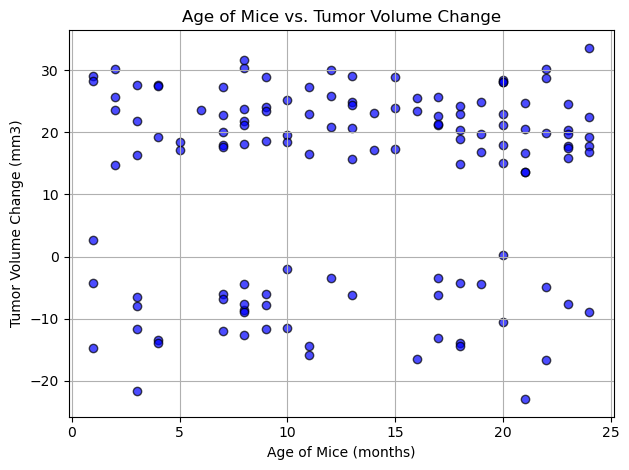

In [240]:
# Determine if there is a coorelation between the age of the mice and the tumor total volume change
# Create a scatter plot of the age of the mice and the tumor total volume change using the csdc_tumor_volume_change DataFrame at the last Timepoint
plt.scatter(csdc_tumor_sort_45["Age_months"], csdc_tumor_sort_45["Tumor Volume (mm3) Change"], color="blue", alpha=0.7, edgecolor="black")
plt.title("Age of Mice vs. Tumor Volume Change")
plt.xlabel("Age of Mice (months)")
plt.ylabel("Tumor Volume Change (mm3)")
plt.grid()
plt.tight_layout()
plt.show()

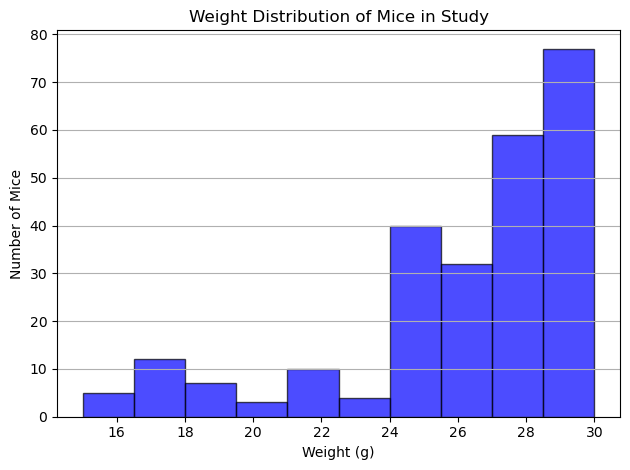

In [241]:
# Create a histogram of the weight distribution of the mice in the study using the mouse_metadata DataFrame
plt.hist(mouse_metadata["Weight (g)"], bins=10, color="blue", alpha=0.7, edgecolor="black")
plt.title("Weight Distribution of Mice in Study")
plt.xlabel("Weight (g)")
plt.ylabel("Number of Mice")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

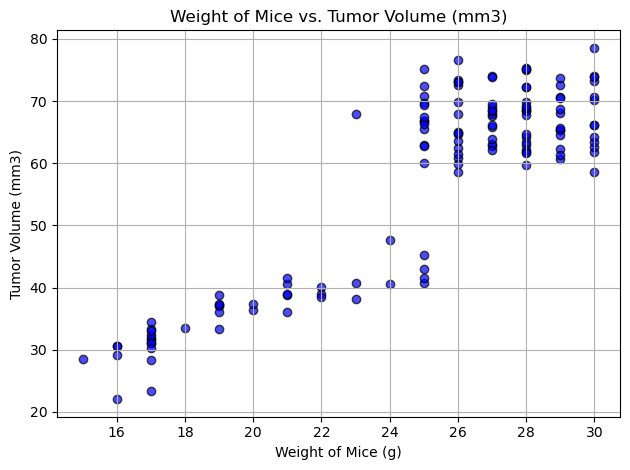

In [242]:
# Create a scatter plot of the weight of the mice and the tumor total volume change using the csdc_tumor_volume_change DataFrame at the last Timepoint
plt.scatter(csdc_tumor_sort_45["Weight (g)"], csdc_tumor_sort_45["Tumor Volume (mm3)"], color="blue", alpha=0.7, edgecolor="black")
plt.title("Weight of Mice vs. Tumor Volume (mm3)")
plt.xlabel("Weight of Mice (g)")
plt.ylabel("Tumor Volume (mm3)")
plt.grid()
plt.tight_layout()
plt.show()

In [243]:
# List unique Drug Regimen values in the capomulin_study_data_clean DataFrame
drug_regimens = capomulin_study_data_clean["Drug Regimen"].unique()
print(drug_regimens)

['Ramicane' 'Capomulin' 'Infubinol' 'Placebo' 'Ceftamin' 'Stelasyn'
 'Zoniferol' 'Ketapril' 'Propriva' 'Naftisol']


In [244]:
# Using the last_timepoint DataFrame, separate the data into DataFrames for each Drug Regimen
ramicane_data = last_timepoint[last_timepoint["Drug Regimen"] == "Ramicane"]
capomulin_data = last_timepoint[last_timepoint["Drug Regimen"] == "Capomulin"]
infubinol_data = last_timepoint[last_timepoint["Drug Regimen"] == "Infubinol"]
placebo_data = last_timepoint[last_timepoint["Drug Regimen"] == "Placebo"]
ceftamin_data = last_timepoint[last_timepoint["Drug Regimen"] == "Ceftamin"]
stelasyn_data = last_timepoint[last_timepoint["Drug Regimen"] == "Stelasyn"]
zoniferol_data = last_timepoint[last_timepoint["Drug Regimen"] == "Zoniferol"]
ketapril_data = last_timepoint[last_timepoint["Drug Regimen"] == "Ketapril"]
propriva_data = last_timepoint[last_timepoint["Drug Regimen"] == "Propriva"]
naftisol_data = last_timepoint[last_timepoint["Drug Regimen"] == "Naftisol"] 

In [245]:
# Create a DataFrame to hold age statistical analysis for each Drug Regimen: mean, median, variance, standard deviation, and SEM
drug_regimen_age_stats = pd.DataFrame(columns=["Drug Regimen", "Mean Age (months)", "Median Age (months)", "Age Variance", "Age Standard Deviation", "Age SEM"])
print(drug_regimen_age_stats)

Empty DataFrame
Columns: [Drug Regimen, Mean Age (months), Median Age (months), Age Variance, Age Standard Deviation, Age SEM]
Index: []


In [246]:
age_stats_list = []

for drug in drug_regimens:
    drug_data = last_timepoint[last_timepoint["Drug Regimen"] == drug]
    mean_age = drug_data["Age_months"].mean()
    median_age = drug_data["Age_months"].median()
    age_variance = drug_data["Age_months"].var()
    age_std_dev = drug_data["Age_months"].std()
    age_sem = drug_data["Age_months"].sem()

    # Append the dictionary to the list
    age_stats_list.append({
        "Drug Regimen": drug, 
        "Mean Age (months)": mean_age, 
        "Median Age (months)": median_age, 
        "Age Variance": age_variance, 
        "Age Standard Deviation": age_std_dev, 
        "Age SEM": age_sem
    })

# Convert the list of dictionaries to a DataFrame
drug_regimen_age_stats = pd.DataFrame(age_stats_list)

# Display the DataFrame
drug_regimen_age_stats

,Drug Regimen,Mean Age (months),Median Age (months),Age Variance,Age Standard Deviation,Age SEM
0,Ramicane,10.840000,9.0,38.973333,6.242863,1.248573
1,Capomulin,14.040000,17.0,61.623333,7.850053,1.570011
2,Infubinol,16.400000,19.0,55.416667,7.444237,1.488847
3,Placebo,10.333333,9.5,42.144928,6.491912,1.325156
4,Ceftamin,12.809524,12.0,67.561905,8.219605,1.793665
5,Stelasyn,13.086957,14.0,61.992095,7.873506,1.641739
6,Zoniferol,12.916667,12.5,36.340580,6.028315,1.230525
7,Ketapril,15.304348,17.0,36.766798,6.063563,1.264340
8,Propriva,9.652174,7.0,49.146245,7.010438,1.461777
9,Naftisol,12.391304,12.0,50.430830,7.101467,1.480758


In [247]:
# Create a DataFrame to hold weight statistical analysis for each Drug Regimen: mean, median, variance, standard deviation, and SEM
drug_regimen_weight_stats = pd.DataFrame(columns=["Drug Regimen", "Mean Weight (g)", "Median Weight (g)", "Weight Variance", "Weight Standard Deviation", "Weight SEM"])
print(drug_regimen_weight_stats)

Empty DataFrame
Columns: [Drug Regimen, Mean Weight (g), Median Weight (g), Weight Variance, Weight Standard Deviation, Weight SEM]
Index: []


In [249]:
weight_stats_list = []

for drug in drug_regimens:
    drug_data = last_timepoint[last_timepoint["Drug Regimen"] == drug]
    mean_weight = drug_data["Weight (g)"].mean()
    median_weight = drug_data["Weight (g)"].median()
    weight_variance = drug_data["Weight (g)"].var()
    weight_std_dev = drug_data["Weight (g)"].std()
    weight_sem = drug_data["Weight (g)"].sem()

    # Append the dictionary to the list
    weight_stats_list.append({
        "Drug Regimen": drug, 
        "Mean Weight (g)": mean_weight, 
        "Median Weight (g)": median_weight, 
        "Weight Variance": weight_variance, 
        "Weight Standard Deviation": weight_std_dev, 
        "Weight SEM": weight_sem
    })

# Convert the list of dictionaries to a DataFrame
drug_regimen_weight_stats = pd.DataFrame(weight_stats_list)

# Display the DataFrame
drug_regimen_weight_stats

,Drug Regimen,Mean Weight (g),Median Weight (g),Weight Variance,Weight Standard Deviation,Weight SEM
0,Ramicane,20.000000,19.0,11.250000,3.354102,0.670820
1,Capomulin,20.120000,21.0,8.193333,2.862400,0.572480
2,Infubinol,27.320000,27.0,4.726667,2.174090,0.434818
3,Placebo,27.958333,28.0,3.780797,1.944427,0.396905
4,Ceftamin,27.380952,28.0,2.747619,1.657594,0.361717
5,Stelasyn,27.913043,28.0,2.901186,1.703287,0.355160
6,Zoniferol,27.833333,28.0,2.231884,1.493949,0.304951
7,Ketapril,28.086957,29.0,3.719368,1.928566,0.402134
8,Propriva,27.217391,27.0,2.996047,1.730909,0.360920
9,Naftisol,27.086957,27.0,2.264822,1.504933,0.313800


In [250]:
# Save the drug_regimen_age_stats DataFrame to a new CSV file
drug_regimen_age_stats_path = os.path.join("cleaned_data", "drug_regimen_age_stats.csv")
drug_regimen_age_stats.to_csv(drug_regimen_age_stats_path, index=False)
print(f"Drug Regimen Age Stats saved to {drug_regimen_age_stats_path}")

Drug Regimen Age Stats saved to cleaned_data\drug_regimen_age_stats.csv


In [251]:
# Save the drug_regimen_weight_stats DataFrame to a new CSV file
drug_regimen_weight_stats_path = os.path.join("cleaned_data", "drug_regimen_weight_stats.csv")
drug_regimen_weight_stats.to_csv(drug_regimen_weight_stats_path, index=False)
print(f"Drug Regimen Weight Stats saved to {drug_regimen_weight_stats_path}")

Drug Regimen Weight Stats saved to cleaned_data\drug_regimen_weight_stats.csv


In [252]:
# Save last_timepoint DataFrame to a new CSV file
last_timepoint_path = os.path.join("cleaned_data", "last_timepoint.csv")
last_timepoint.to_csv(last_timepoint_path, index=False)
print(f"Last Timepoint data saved to {last_timepoint_path}")

Last Timepoint data saved to cleaned_data\last_timepoint.csv


In [253]:
drug_regimens

array(['Ramicane', 'Capomulin', 'Infubinol', 'Placebo', 'Ceftamin',
       'Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol'],
      dtype=object)

In [254]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor change in volume for each drug regimen
# Create a DataFrame to hold tumor volume change statistical analysis for each Drug Regimen: mean, median, variance, standard deviation, and SEM
drug_regimen_tumor_volume_change_stats = pd.DataFrame(columns=["Drug Regimen", "Mean Tumor Volume (mm3) Change", "Median Tumor Volume (mm3) Change", "Tumor Volume (mm3) Change Variance", "Tumor Volume (mm3) Change Standard Deviation", "Tumor Volume (mm3) Change SEM"])
print(drug_regimen_tumor_volume_change_stats)

Empty DataFrame
Columns: [Drug Regimen, Mean Tumor Volume (mm3) Change, Median Tumor Volume (mm3) Change, Tumor Volume (mm3) Change Variance, Tumor Volume (mm3) Change Standard Deviation, Tumor Volume (mm3) Change SEM]
Index: []


In [255]:
tumor_vol_change_stats_list = []

for drug in drug_regimens:
    drug_data = last_timepoint[last_timepoint["Drug Regimen"] == drug]
    mean_tumor_vol_change = drug_data["Tumor Volume (mm3) Change"].mean()
    median_tumor_vol_change = drug_data["Tumor Volume (mm3) Change"].median()
    tumor_vol_change_variance = drug_data["Tumor Volume (mm3) Change"].var()
    tumor_vol_change_std_dev = drug_data["Tumor Volume (mm3) Change"].std()
    tumor_vol_change_sem = drug_data["Tumor Volume (mm3) Change"].sem()

    # Append the dictionary to the list
    tumor_vol_change_stats_list.append({
        "Drug Regimen": drug, 
        "Mean Tumor Volume (mm3) Change": mean_tumor_vol_change, 
        "Median Tumor Volume (mm3) Change": median_tumor_vol_change, 
        "Tumor Volume (mm3) Change Variance": tumor_vol_change_variance, 
        "Tumor Volume (mm3) Change Standard Deviation": tumor_vol_change_std_dev, 
        "Tumor Volume (mm3) Change SEM": tumor_vol_change_sem
    })

# Convert the list of dictionaries to a DataFrame
drug_regimen_tumor_vol_change_stats = pd.DataFrame(tumor_vol_change_stats_list)

# Display the DataFrame
drug_regimen_tumor_vol_change_stats

,Drug Regimen,Mean Tumor Volume (mm3) Change,Median Tumor Volume (mm3) Change,Tumor Volume (mm3) Change Variance,Tumor Volume (mm3) Change Standard Deviation,Tumor Volume (mm3) Change SEM
0,Ramicane,-9.835007,-9.063864,25.638318,5.063429,1.012686
1,Capomulin,-9.286652,-7.925976,36.544077,6.045170,1.209034
2,Infubinol,17.680661,20.089095,102.682303,10.133228,2.026646
3,Placebo,22.705203,22.904068,18.412008,4.290922,0.875881
4,Ceftamin,18.496626,18.224868,9.548324,3.090036,0.674301
5,Stelasyn,21.646513,20.072894,19.365868,4.400667,0.917602
6,Zoniferol,19.960289,19.350996,11.739024,3.426226,0.699375
7,Ketapril,24.894226,23.617222,14.839357,3.852189,0.803237
8,Propriva,20.167966,19.490934,21.197866,4.604114,0.960024
9,Naftisol,22.699463,20.741070,20.980054,4.580399,0.955079


In [256]:
# Save the drug_regimen_tumor_vol_change_stats DataFrame to a new CSV file
drug_regimen_tumor_vol_change_stats_path = os.path.join("cleaned_data", "drug_regimen_tumor_vol_change_stats.csv")
drug_regimen_tumor_vol_change_stats.to_csv(drug_regimen_tumor_vol_change_stats_path, index=False)
print(f"Drug Regimen Tumor Volume Change Stats saved to {drug_regimen_tumor_vol_change_stats_path}")

Drug Regimen Tumor Volume Change Stats saved to cleaned_data\drug_regimen_tumor_vol_change_stats.csv


In [257]:
# Create new DataFrame for the Tumor Volume (mm3) Change, Age, and Weight statistic summarys for each Drug Regimen
age_stats_drug_index = drug_regimen_age_stats.copy()
weight_stats_drug_index = drug_regimen_weight_stats.copy()
tumor_vol_change_stats_drug_index = drug_regimen_tumor_vol_change_stats.copy()

In [258]:
# Change the index of the new DataFrames to the Drug Regimen column
age_stats_drug_index = age_stats_drug_index.set_index("Drug Regimen")
weight_stats_drug_index = weight_stats_drug_index.set_index("Drug Regimen")
tumor_vol_change_stats_drug_index = tumor_vol_change_stats_drug_index.set_index("Drug Regimen")

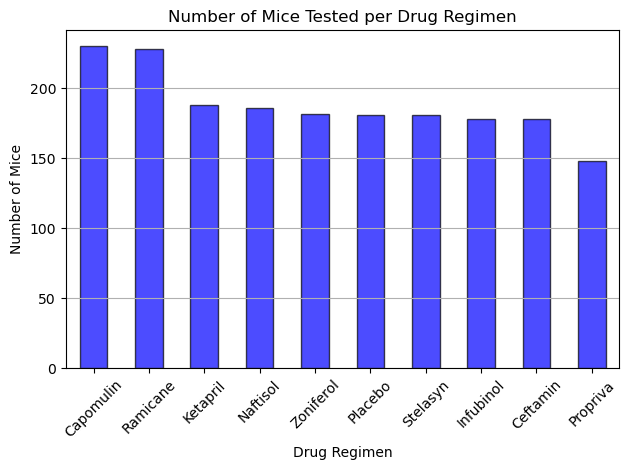

In [259]:
# Create bar plot using the Pandas plot method to show the number of mice tested per Drug Regimen
drug_regimen_counts = capomulin_study_data_clean["Drug Regimen"].value_counts()
drug_regimen_counts.plot(kind="bar", color="blue", alpha=0.7, edgecolor="black", title="Number of Mice Tested per Drug Regimen")
plt.xlabel("Drug Regimen")
plt.xticks(rotation=45)
plt.ylabel("Number of Mice")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("data_visualizations/Number_of_Mice_Tested_per_Drug_Regimen_Pandas.png")
plt.show()
plt.close()

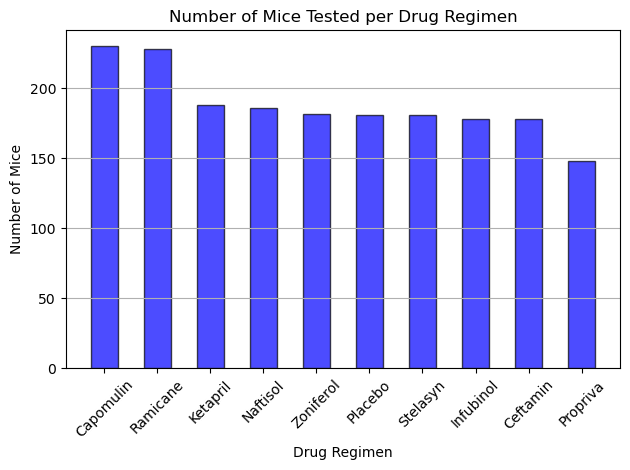

In [260]:
# Create bar plot using the Matplotlib plot method to show the number of mice tested per Drug Regimen
drug_regimen_counts_2 = drug_regimen_counts.sort_values(ascending=False)
plt.bar(drug_regimen_counts_2.index, drug_regimen_counts_2.values, color="blue", alpha=0.7, edgecolor="black", width=0.5)
plt.title("Number of Mice Tested per Drug Regimen")
plt.xlabel("Drug Regimen")
plt.xticks(rotation=45)
plt.ylabel("Number of Mice")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("data_visualizations/Number_of_Mice_Tested_per_Drug_Regimen_Matplotlib.png")
plt.show()
plt.close()

In [261]:
male_female = mouse_metadata["Sex"].unique()
male_female

array(['Male', 'Female'], dtype=object)

In [262]:
# Create a DataFrame with the unique Sex values in the mouse_metadata DataFrame
mouse_sex = pd.DataFrame(columns = ["Sex", "Number of Mice"])
print(mouse_sex)

Empty DataFrame
Columns: [Sex, Number of Mice]
Index: []


In [263]:
# Create a list of dictionaries to hold the number of mice for each sex and append the dictionary to the list
sex_counts = []

for Sex in male_female:
    df_sex = mouse_metadata[mouse_metadata["Sex"] == Sex]
    count_sex_mice = df_sex["Sex"].count()

    # Append the dictionary to the list
    sex_counts.append({
        "Sex": Sex,
        "Number of Mice": count_sex_mice
    })

# Convert the list of dictionaries to a DataFrame
mouse_sex = pd.DataFrame(sex_counts)

# Display the DataFrame
mouse_sex

,Sex,Number of Mice
0,Male,125
1,Female,124


In [264]:
# Change the index of the new DataFrame to Sex
mouse_sex_index = mouse_sex.set_index(["Sex"])
mouse_sex_index

,Number of Mice
Sex,
Male,125
Female,124


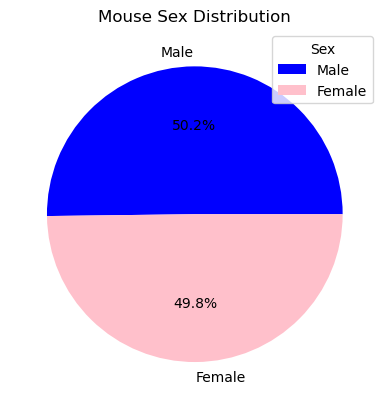

In [265]:
# Create a pie chart using the Pandas Plot method to show the distribution Female vs Male mice
sex_plot_pandas = mouse_sex_index.plot.pie(y="Number of Mice", colors=("Blue","Pink"), labels=mouse_sex_index.index, autopct="%1.1f%%", legend=False)
sex_plot_pandas.set_title("Mouse Sex Distribution")
sex_plot_pandas.set_ylabel("")
sex_plot_pandas.legend(title="Sex", loc="upper right")
plt.savefig("data_visualizations/pie_chart_pandas.png")
plt.show()
plt.close()

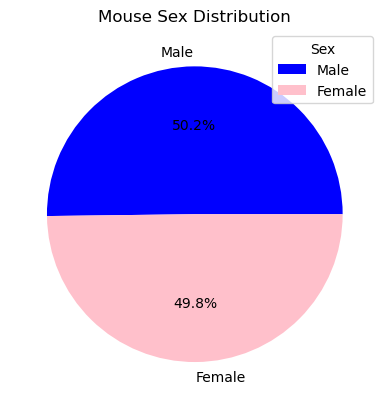

In [266]:
# Create a pie chart using the Matplotlib method to show the distribution Female vs Male mice
plt.pie(mouse_sex_index["Number of Mice"], labels=mouse_sex_index.index, colors=("Blue","Pink"), autopct="%1.1f%%")
plt.title("Mouse Sex Distribution")
plt.legend(loc="upper right", title="Sex")
plt.savefig("data_visualizations/pie_chart_matplotlib.png")
plt.show()
plt.close()


In [268]:
# Create a DataFrame to calculate the Quartiles, IQR, Lower Bound, and Upper Bound for the Tumor Volume (mm3) Change for the four most promising treatment regimens: Capomulin, Ramicane, Infubinol, and Ceftamin
tumor_vol_change_quartiles_outliers = last_timepoint.copy()
tumor_vol_change_quartiles_outliers.drop(columns=["Mouse ID", "Timepoint", "Tumor Volume % Reduction", "Initial Tumor Volume (mm3)", "Sex", "Age_months", "Weight (g)"], inplace=True)

# Create a list of drugs to drop from the DataFrame
drugs_to_drop = ["Placebo", "Stelasyn", "Zoniferol", "Ketapril", "Propriva", "Naftisol"]

# Create a boolean mask to filter out the drugs to drop
mask = tumor_vol_change_quartiles_outliers["Drug Regimen"].isin(drugs_to_drop)

tumor_vol_change_quartiles_outliers.drop(tumor_vol_change_quartiles_outliers[mask].index , inplace=True)
tumor_vol_change_quartiles_outliers

,Drug Regimen,Tumor Volume (mm3),Tumor Volume (mm3) Change
9,Ramicane,22.050126,-22.949874
19,Capomulin,23.343598,-21.656402
29,Capomulin,28.484033,-16.515967
39,Capomulin,28.430964,-16.569036
49,Ramicane,29.128472,-15.871528
...,...,...,...
1379,Ramicane,35.936136,-9.063864
1380,Ramicane,34.299660,-10.700340
1381,Ramicane,38.493336,-6.506664
1382,Ramicane,31.791754,-13.208246


In [269]:
# Print the unique Drug Regimen values in the tumor_vol_change_quartiles_outliers DataFrame to ensure the drugs to drop were removed
tumor_vol_change_quartiles_outliers["Drug Regimen"].unique()

# Print the unique Drug Regimen values in the tumor_vol_change_quartiles_outliers DataFrame to ensure ['Ramicane', 'Capomulin', 'Infubinol', 'Ceftamin'] data was not removed
tumor_vol_change_quartiles_outliers["Drug Regimen"].value_counts()

Drug Regimen
Ramicane     25
Capomulin    25
Infubinol    25
Ceftamin     21
Name: count, dtype: int64

In [270]:
# Create a list of dictionaries to hold the Quartiles, IQR, Lower Bound, and Upper Bound for the Tumor Volume (mm3) Change for each Drug Regimen
tumor_vol_change_quartiles = []

for drug in ["Ramicane", "Capomulin", "Infubinol", "Ceftamin"]:
    drug_data = tumor_vol_change_quartiles_outliers[tumor_vol_change_quartiles_outliers["Drug Regimen"] == drug]
    quartiles = drug_data["Tumor Volume (mm3) Change"].quantile([0.25, 0.5, 0.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)

    # Append the dictionary to the list
    tumor_vol_change_quartiles.append({
        "Drug Regimen": drug, 
        "Lower Quartile": lowerq, 
        "Upper Quartile": upperq, 
        "IQR": iqr, 
        "Lower Bound": lower_bound, 
        "Upper Bound": upper_bound
    })

# Convert the list of dictionaries to a DataFrame
tumor_vol_change_quartiles_df = pd.DataFrame(tumor_vol_change_quartiles)

# Display the DataFrame
tumor_vol_change_quartiles_df

,Drug Regimen,Lower Quartile,Upper Quartile,IQR,Lower Bound,Upper Bound
0,Ramicane,-13.439530,-6.506664,6.932866,-23.838830,3.892636
1,Capomulin,-13.103762,-4.840780,8.262982,-25.498234,7.553693
2,Infubinol,17.328716,21.142692,3.813976,11.607752,26.863656
3,Ceftamin,16.386660,19.729837,3.343176,11.371896,24.744601
